In [1]:
using DataFrames, FileIO, DelimitedFiles, DataStructures
using Plots, Optim, LsqFit, LinearAlgebra

In [2]:
function read_pop_file(filename, resnames)
    deprotonated_fraction =  Array{Float64, 1}(undef, length(resnames))
    pop_file = readdlm(filename, header = true)[1][2:end, 2:end]

    k = 0
    for resname in resnames
        k+=1
        if resname == "GL4"
            deprotonated_fraction[k] = pop_file[k, 3:end][1]
        elseif resname == "AS4"
            deprotonated_fraction[k] = pop_file[k, 3:end][1]
        elseif resname == "HIP"
            deprotonated_fraction[k] = 1 - pop_file[k, 3:end][1]
        elseif resname == "LYS"
            deprotonated_fraction[k] = 1 - pop_file[k, 3:end][1]
        elseif resname == "CYX"
            deprotonated_fraction[k] = 1 - pop_file[k, 3:end][1]
        elseif resname == "TYR"
            deprotonated_fraction[k] = 1 - pop_file[k, 3:end][1]
        end
    end
    
    return deprotonated_fraction
end

read_pop_file (generic function with 1 method)

In [45]:
function just_read_cpout_file(filename, resnames, nframes)

    cpout = readdlm(filename)
    estados = Array{Int64, 2}(undef, t, nframes)
    let linea = 1, i = 1
        # Hay más de nframes frames y por lo tanto más records
        # de protonaciones, pero ya corté las trayectorias p/ esa longitud.
        while i <= nframes
            if cpout[linea, 1] == "Time:"
                global estados[:, i] = cpout[linea + 1:linea + t, 4]
                linea += t
                i += 1
            else
                linea += 1
            end
        end
    end
    return estados
end

just_read_cpout_file (generic function with 1 method)

In [296]:
# Leo el archivo cpout con los estados de protonación de c/ a residuo a c/ frame.
# Luego obtengo la fracción de tiempo en q estuvo en el q el residuo estuvo en el estado 0
# y con eso obtengo la fracción de tiempo en q estuvo desprotonado.
function read_cpout_file(filename, resnames, nframes, mascara = [0])

    cpout = readdlm(filename)
    estados = Array{Int64, 2}(undef, t, nframes)
    let linea = 1, i = 1
        # Hay más de nframes frames y por lo tanto más records
        # de protonaciones, pero ya corté las trayectorias p/ esa longitud.
        while i <= nframes
            if cpout[linea, 1] == "Time:"
                global estados[:, i] = cpout[linea + 1:linea + t, 4]
                linea += t
                i += 1
            else
                linea += 1
            end
        end
    end
    
    deprotonated_fraction =  Array{Float64, 1}(undef, length(resnames))
    for k in 1:titrable_cnt
        if mascara[1] == 0
            cero, = counter(estados[k, :])
        else 
            cero, = counter(estados[k, mascara])
        end
        resname = titrable_resnames[k]

        if resname == "GL4"
            deprotonated_fraction[k] = cero[2] / nframes
        elseif resname == "AS4"
            deprotonated_fraction[k] = cero[2] / nframes
        elseif resname == "HIP"
            deprotonated_fraction[k] = 1 - cero[2] / nframes
        elseif resname == "LYS"
            deprotonated_fraction[k] = 1 - cero[2] / nframes
        elseif resname == "CYX"
            deprotonated_fraction[k] = 1 - cero[2] / nframes
        elseif resname == "TYR"
            deprotonated_fraction[k] = 1 - cero[2] / nframes
        end
    end
    
    if mascara[1] == 0
        return deprotonated_fraction, estados
    else 
        return deprotonated_fraction, estados[:, mascara]
    end
    
end

read_cpout_file (generic function with 2 methods)

In [4]:
# Get ready
CASA = "/home/pbarletta/labo/20/cph_obp"
casa = "/home/pbarletta/labo/20/cph_obp/run/eol"
dir_cpout = joinpath(casa, "pdt", "cph_outputs")

nframes = 144000
nframes_per_trj = 144000 ÷ 12
phs = [ 2.0 ; 2.5 ; 3.0 ; 3.5 ; 4.0 ; 4.5 ; 5.0 ; 5.5 ; 6.0 ; 6.5 ; 7.0 ; 7.5 ]
pdt_steps = 1
suffix_pka_file = "_pka"
suffix_pop_file = "_pop"
titrable_resis = [4, 5, 11, 13, 20, 24, 30, 33, 37, 39, 40,
    48, 58, 73, 77, 78, 87, 93, 94, 97, 117]
titrable_resnames = ["GL4", "GL4", "HIP", "GL4", "GL4", "AS4",
    "AS4", "GL4", "AS4", "GL4", "AS4", "GL4", "AS4", "GL4", "AS4",
    "GL4", "AS4", "GL4", "GL4", "HIP", "AS4"]
titrable_cnt = length(titrable_resis)
global const def_pka_as4 = 3.71
global const def_pka_gl4 = 4.15
global const def_pka_hip = 6.04;

In [5]:
def_res_pka = Array{Float64, 1}(undef, titrable_cnt)

for i in 1:titrable_cnt
    if titrable_resnames[i] == "AS4"
        def_res_pka[i] = def_pka_as4
    elseif titrable_resnames[i] == "GL4"
        def_res_pka[i] = def_pka_gl4
    elseif titrable_resnames[i] == "HIP"
        def_res_pka[i] = def_pka_hip
    end
end

## Leo los clusters

In [249]:
texto = readdlm(joinpath(casa, "todo_cluster", "n_cluster_kmean.dat"), header=true)[1][:, 2]
masca = convert(Array{Bool,1}, texto)
frames_c1 = findall(masca)
n = length(frames_c1)
t = 21 # tritable residues: 21


trj_idx_c1 = Array{Int64,1}(undef, n)
trj_add_c1 = Array{Int64,1}(undef, n)
indices_frms_c1 = Array{Array{Int64, 1}, 1}()
idx = Array{Int64, 1}()

for i in 1:n
    # sumo 1 pq después voy a usar trj_idx_c1 p/ indexar los phs
    # y Julia tiene 1-index
    trj_idx_c1[i] = frames_c1[i] ÷ nframes_per_trj + 1
    trj_add_c1[i] = frames_c1[i] % nframes_per_trj
    
    if trj_add_c1[i] == 0
        # Justo frames_c1[i] es múltimo del nro de frames. Hay q leer
        # el último frame de una trayectoria
        trj_idx_c1[i] -= 1
        trj_add_c1[i] = nframes_per_trj
    end
    
    if (i != 1) && (trj_idx_c1[i-1] != trj_idx_c1[i])
        # Listo con este pH        
        push!(indices_frms_c1, copy(idx))
        empty!(idx)
    elseif i == n
        # Listo con todo
        push!(idx, trj_add_c1[i])
        push!(indices_frms_c1, copy(idx))
    end
    
    push!(idx, trj_add_c1[i])
end

## Leo cpout ordenada por pH

In [173]:
deprotonated_fraction2 =  Array{Float64, 2}(undef, titrable_cnt, length(phs))
for i in 1:length(phs)
    cpout_filename = joinpath(casa, dir_cpout, 
        string("reordered_cpouts.pH_", phs[i], "0"))
    
    println(cpout_filename)
    
    deprotonated_fraction2[:, i], = read_cpout_file(cpout_filename,
        titrable_resnames, nframes_per_trj, indices_frms_c1[i]);
end

/home/pbarletta/labo/20/cph_obp/run/eol/pdt/cph_outputs/reordered_cpouts.pH_2.00
/home/pbarletta/labo/20/cph_obp/run/eol/pdt/cph_outputs/reordered_cpouts.pH_2.50
/home/pbarletta/labo/20/cph_obp/run/eol/pdt/cph_outputs/reordered_cpouts.pH_3.00
/home/pbarletta/labo/20/cph_obp/run/eol/pdt/cph_outputs/reordered_cpouts.pH_3.50
/home/pbarletta/labo/20/cph_obp/run/eol/pdt/cph_outputs/reordered_cpouts.pH_4.00
/home/pbarletta/labo/20/cph_obp/run/eol/pdt/cph_outputs/reordered_cpouts.pH_4.50
/home/pbarletta/labo/20/cph_obp/run/eol/pdt/cph_outputs/reordered_cpouts.pH_5.00
/home/pbarletta/labo/20/cph_obp/run/eol/pdt/cph_outputs/reordered_cpouts.pH_5.50
/home/pbarletta/labo/20/cph_obp/run/eol/pdt/cph_outputs/reordered_cpouts.pH_6.00
/home/pbarletta/labo/20/cph_obp/run/eol/pdt/cph_outputs/reordered_cpouts.pH_6.50
/home/pbarletta/labo/20/cph_obp/run/eol/pdt/cph_outputs/reordered_cpouts.pH_7.00
/home/pbarletta/labo/20/cph_obp/run/eol/pdt/cph_outputs/reordered_cpouts.pH_7.50


In [211]:
i = 5

filename = joinpath(casa, dir_cpout,  string("reordered_cpouts.pH_", phs[i], "0"))
resnames =  titrable_resnames
nframes = nframes_per_trj
mascara = indices_frms_c1[i]

    cpout = readdlm(filename)
    estados = Array{Int64, 2}(undef, t, nframes)
    let linea = 1, i = 1
        # Hay más de nframes frames y por lo tanto más records
        # de protonaciones, pero ya corté las trayectorias p/ esa longitud.
        while i <= nframes
            if cpout[linea, 1] == "Time:"
                global estados[:, i] = cpout[linea + 1:linea + t, 4]
                linea += t
                i += 1
            else
                linea += 1
            end
        end
    end
    
    deproto_fraction =  Array{Float64, 1}(undef, length(resnames))
    for k in 1:titrable_cnt
        if mascara[1] == 0
            cero, = counter(estados[k, :])
        else 
            cero, = counter(estados[k, mascara])
        end
        resname = titrable_resnames[k]

        if resname == "GL4"
            deproto_fraction[k] = cero[2] / nframes
        elseif resname == "AS4"
            deproto_fraction[k] = cero[2] / nframes
        elseif resname == "HIP"
            deproto_fraction[k] = 1 - cero[2] / nframes
        elseif resname == "LYS"
            deproto_fraction[k] = 1 - cero[2] / nframes
        elseif resname == "CYX"
            deproto_fraction[k] = 1 - cero[2] / nframes
        elseif resname == "TYR"
            deproto_fraction[k] = 1 - cero[2] / nframes
        end
    end

In [297]:
i = 4
depro_4m, esta_4m = read_cpout_file(cpout_filename,
        titrable_resnames, nframes_per_trj, indices_frms_c1[i]);

In [298]:
i = 5
depro_5m, esta_5m = read_cpout_file(cpout_filename,
        titrable_resnames, nframes_per_trj, indices_frms_c1[i]);

In [299]:
i = 4
depro_4, esta_4 = read_cpout_file(cpout_filename,
        titrable_resnames, nframes_per_trj);

In [300]:
i = 5
depro_5, esta_5 = read_cpout_file(cpout_filename,
        titrable_resnames, nframes_per_trj);

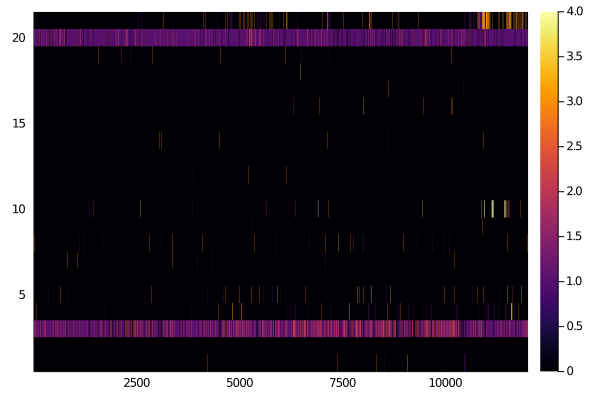

In [301]:
heatmap(esta_5)

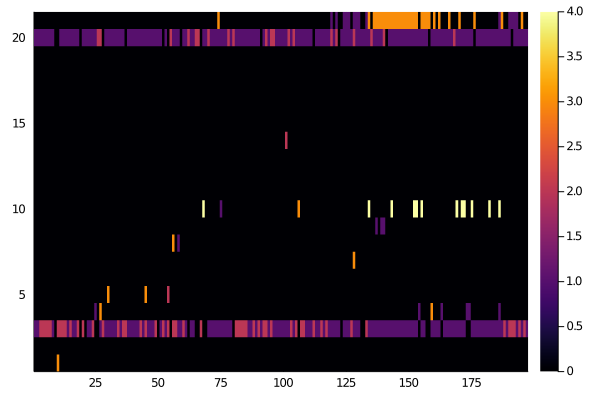

In [302]:
heatmap(esta_5m)

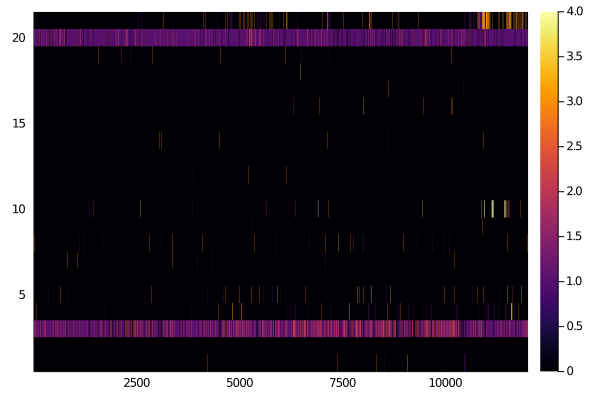

In [303]:
heatmap(esta_4)

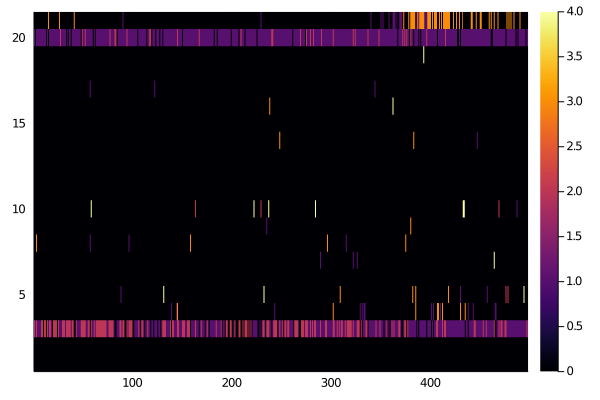

In [304]:
heatmap(esta_4m)

In [269]:
esta_5[:, indices_frms_c1[5]]

21×197 Array{Int64,2}:
 0  0  0  0  0  0  0  0  0  3  0  0  0  …  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 1  1  2  2  2  2  2  1  0  2  2  2  2     1  1  2  1  2  2  2  1  2  1  2  1
 0  0  0  0  0  0  0  0  0  0  0  0  0     1  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  …  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     4  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  …  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0   

In [268]:
esta_5

21×12000 Array{Int64,2}:
 0  0  0  0  0  0  0  0  0  0  0  0  0  …  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 1  1  2  2  1  2  2  1  1  1  1  2  1     2  2  1  2  1  1  1  1  1  2  1  1
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  3  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  …  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  3  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  …  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0 

In [221]:
depro_4

21-element Array{Float64,1}:
 0.9973333333333333
 0.9988333333333334
 0.89475
 0.971
 0.9854166666666667
 0.9999166666666667
 0.9969166666666667
 0.9889166666666667
 0.9989166666666667
 0.9831666666666666
 1.0
 0.998
 1.0
 0.9956666666666667
 1.0
 0.9969166666666667
 0.9990833333333333
 0.9996666666666667
 0.9958333333333333
 0.9376666666666666
 0.9289166666666666

In [222]:
depro_5

21-element Array{Float64,1}:
 0.01633333333333333
 0.016416666666666666
 0.9980833333333333
 0.01575
 0.016166666666666666
 0.016416666666666666
 0.01633333333333333
 0.01625
 0.016166666666666666
 0.01525
 0.016416666666666666
 0.016416666666666666
 0.016416666666666666
 0.01633333333333333
 0.016416666666666666
 0.016416666666666666
 0.016416666666666666
 0.016416666666666666
 0.016416666666666666
 0.9986666666666667
 0.012666666666666666

In [205]:
deproto_fraction

21-element Array{Float64,1}:
 0.00175
 0.0030833333333333333
 0.9109166666666667
 0.00025
 0.00025
 0.017666666666666667
 0.0023333333333333335
 0.0015
 0.020166666666666666
 0.0014166666666666668
 0.058333333333333334
 0.019416666666666665
 0.045
 0.005416666666666667
 0.014916666666666667
 0.003416666666666667
 0.04066666666666666
 0.017583333333333333
 0.0005833333333333334
 0.9109166666666667
 0.0006666666666666666

In [207]:
deproto_fraction

21-element Array{Float64,1}:
 0.28575
 0.47758333333333336
 0.02516666666666667
 0.05975
 0.03325
 0.816
 0.26866666666666666
 0.17991666666666667
 0.8011666666666667
 0.08675
 0.8715
 0.78825
 0.9518333333333333
 0.38875
 0.7845833333333333
 0.28933333333333333
 0.6985
 0.6734166666666667
 0.11341666666666667
 0.01866666666666672
 0.15566666666666668

In [212]:
deproto_fraction

21-element Array{Float64,1}:
 0.008583333333333333
 0.011916666666666667
 0.98525
 0.00175
 0.0010833333333333333
 0.01475
 0.004666666666666667
 0.004833333333333334
 0.014666666666666666
 0.00225
 0.01525
 0.0145
 0.016
 0.008416666666666666
 0.014666666666666666
 0.006
 0.01475
 0.013833333333333333
 0.0030833333333333333
 0.9840833333333333
 0.0019166666666666666

## Leo los \_pop files

In [203]:
# Obtengo las poblaciones deprotonadas de c/ residuo a c/ valor de pH
# Leo el State 0 de c/ residuo. P/ lods residuos ácidos (GL4, AS4)
# el state 0 es deprotonado, p/ los básicos es protonado.
# Usaré estas poblaciones p/ ajustar la curva de Hill y obtener el valor de pKa.
deprotonated_fraction =  Array{Float64, 2}(undef, titrable_cnt, length(phs))
for i in 1:length(phs)
    pop_filename = joinpath(dir_cpout, string(phs[i], "_pop"))
    deprotonated_fraction[:, i] = read_pop_file(pop_filename, titrable_resnames)
end

## Leo los \_pka files

In [14]:
# P/ ajustar bien la curva de Hill y obtener los parámetros n y pKa conviene
# empezar con unos buenos parámetros iniciales. P/ n eso es 1.0 y p/ pKa será
# el valor de pKa predicho durante la corrida con menor Offset. Por eso leo
# estos archivos de _pka, p/ obtener los pka predichos y sólo usar el q venga
# con de la corrida con menor offset. Cualquier cosa: ver papers de Swails.

res_offset_all = Array{Float64, 2}(undef, titrable_cnt, length(phs))
res_pka_pred_all = Array{Float64, 2}(undef, titrable_cnt, length(phs))
res_pka_pred =  Array{Float64, 1}(undef, titrable_cnt)

for i = 1:length(phs)
    pka_file = readdlm(joinpath(dir_cpout, string(phs[i], "_pka")),
        header = true)[1][1:end-1, 1:end-1]    
    res_offset_all[:, i] = pka_file[:, 5]
    res_pka_pred_all[:, i] = pka_file[:, 7]
end

for i = 1:titrable_cnt
    min_offset_idx = findmin(abs.(res_offset_all[i, :]))[2]
    res_pka_pred[i] = res_pka_pred_all[i, min_offset_idx]
end

## Determino Hill coefficients and pKas

In [175]:
# Hill coefficient and pKa for each residue 
res_pka =  Array{Float64, 1}(undef, titrable_cnt)
res_hil =  Array{Float64, 1}(undef, titrable_cnt)

# Hill function
@. f(x, hill_coef) = 1 / (1 + 10 ^(hill_coef[1]*(hill_coef[2] - x)) )
xdata = phs

# Fit the curves
for i = 1:titrable_cnt
    hill_coef = [1. ; res_pka_pred[i]]
    fit = curve_fit(f, xdata, deprotonated_fraction2[i, :], hill_coef)    
    res_hil[i] = fit.param[1]
    res_pka[i] = fit.param[2]
end

# Guardo los pkas obtenidos
writedlm(joinpath(CASA, "rtdos_log", "c1_pka_eol"), [titrable_resnames titrable_resis res_pka res_hil])

## Diferencias entre pka calculado y default

In [176]:
etiquetas = string.(titrable_resnames, " ", titrable_resis)
dif_res_pka = map(-, res_pka, def_res_pka);

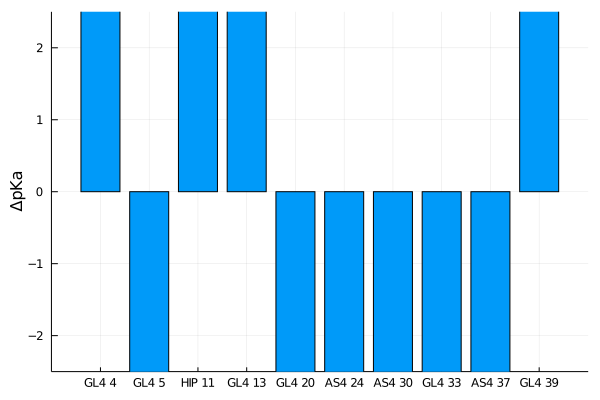

In [177]:
bar(etiquetas[1:10], dif_res_pka[1:10], label = :none,
    ylim = (-2.5, 2.5), ylabel = "ΔpKa")

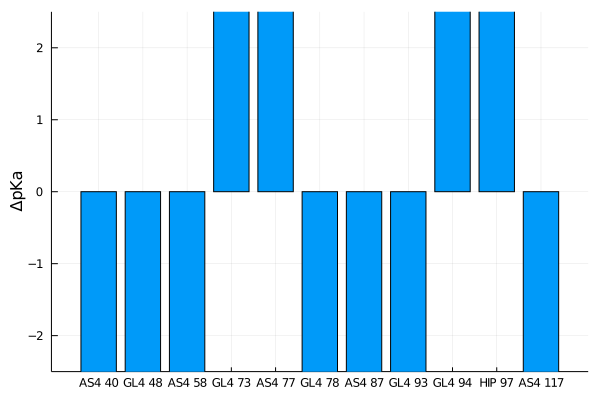

In [178]:
bar(etiquetas[11:end], dif_res_pka[11:end], label = :none,
    ylim = (-2.5, 2.5), ylabel = "ΔpKa")

### Plotteo

In [179]:
function titration_curve(n, pKa, x)
    return (1 / (1 + 10 ^(n*(pKa - x))))
end
x = collect(1:.1:14);

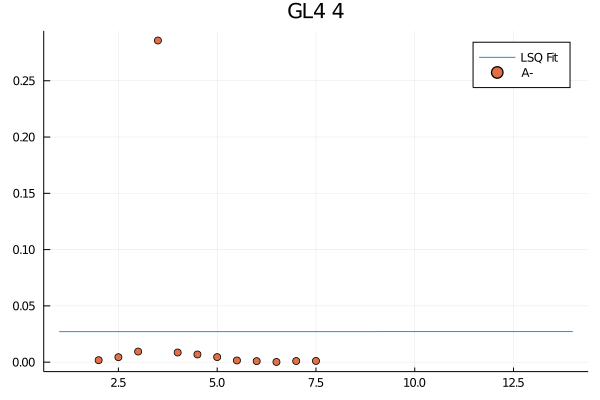

In [181]:
i = 1
    plot(x, titration_curve.(res_hil[i], res_pka[i], x),
        label = "LSQ Fit",
        title = string(titrable_resnames[i], " ", titrable_resis[i]))
    
    scatter!(xdata, deprotonated_fraction2[i, :],
        label = "A-")
    
    annotate!((res_pka[i] + 1.5), .5, 
        Plots.text(string("pKa = ", round(res_pka[i], digits = 2))))
    annotate!((res_pka[i] + 1.2), .4, 
        Plots.text(string("n = ", round(res_hil[i], digits = 2))))

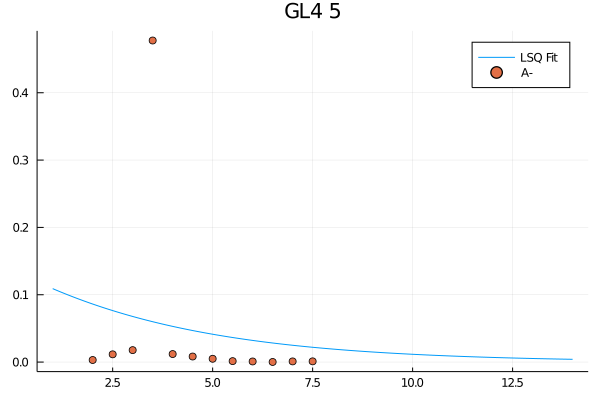

In [182]:
i = 2
    plot(x, titration_curve.(res_hil[i], res_pka[i], x),
        label = "LSQ Fit",
        title = string(titrable_resnames[i], " ", titrable_resis[i]))
    
    scatter!(xdata, deprotonated_fraction2[i, :],
        label = "A-")
    
    annotate!((res_pka[i] + 1.5), .5, 
        Plots.text(string("pKa = ", round(res_pka[i], digits = 2))))
    annotate!((res_pka[i] + 1.2), .4, 
        Plots.text(string("n = ", round(res_hil[i], digits = 2))))

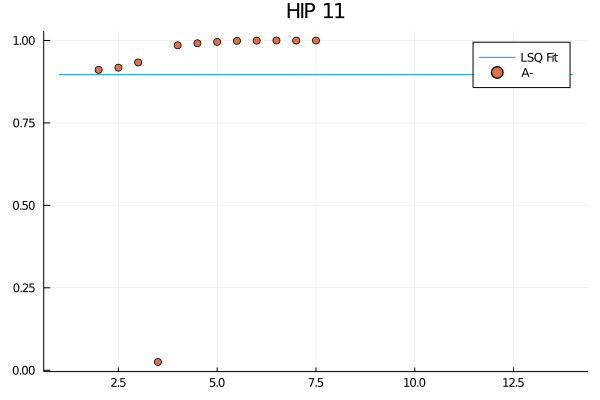

In [183]:
i = 3
    plot(x, titration_curve.(res_hil[i], res_pka[i], x),
        label = "LSQ Fit",
        title = string(titrable_resnames[i], " ", titrable_resis[i]))
    
    scatter!(xdata, deprotonated_fraction2[i, :],
        label = "A-")
    
    annotate!((res_pka[i] + 1.5), .5, 
        Plots.text(string("pKa = ", round(res_pka[i], digits = 2))))
    annotate!((res_pka[i] + 1.2), .4, 
        Plots.text(string("n = ", round(res_hil[i], digits = 2))))

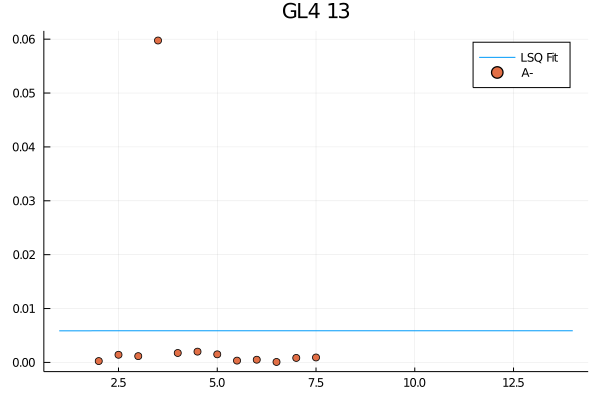

In [184]:
i = 4
    plot(x, titration_curve.(res_hil[i], res_pka[i], x),
        label = "LSQ Fit",
        title = string(titrable_resnames[i], " ", titrable_resis[i]))
    
    scatter!(xdata, deprotonated_fraction2[i, :],
        label = "A-")
    
    annotate!((res_pka[i] + 1.5), .5, 
        Plots.text(string("pKa = ", round(res_pka[i], digits = 2))))
    annotate!((res_pka[i] + 1.2), .4, 
        Plots.text(string("n = ", round(res_hil[i], digits = 2))))

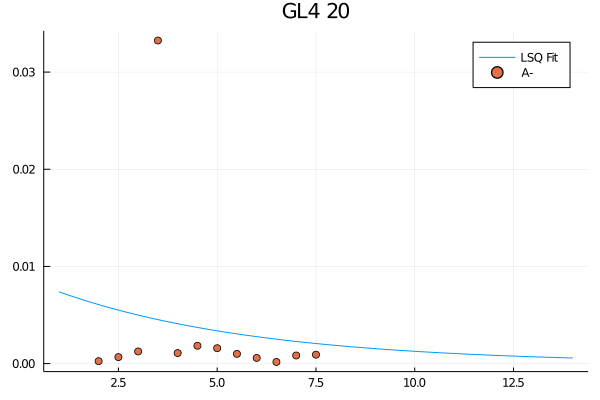

In [185]:
i = 5
    plot(x, titration_curve.(res_hil[i], res_pka[i], x),
        label = "LSQ Fit",
        title = string(titrable_resnames[i], " ", titrable_resis[i]))
    
    scatter!(xdata, deprotonated_fraction2[i, :],
        label = "A-")
    
    annotate!((res_pka[i] + 1.5), .5, 
        Plots.text(string("pKa = ", round(res_pka[i], digits = 2))))
    annotate!((res_pka[i] + 1.2), .4, 
        Plots.text(string("n = ", round(res_hil[i], digits = 2))))

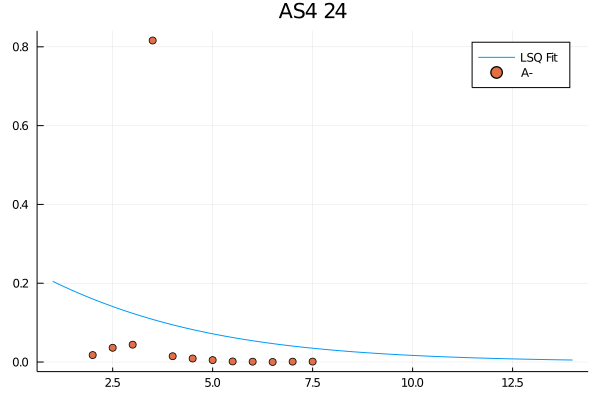

In [186]:
i = 6
    plot(x, titration_curve.(res_hil[i], res_pka[i], x),
        label = "LSQ Fit",
        title = string(titrable_resnames[i], " ", titrable_resis[i]))
    
    scatter!(xdata, deprotonated_fraction2[i, :],
        label = "A-")
    
    annotate!((res_pka[i] + 1.5), .5, 
        Plots.text(string("pKa = ", round(res_pka[i], digits = 2))))
    annotate!((res_pka[i] + 1.2), .4, 
        Plots.text(string("n = ", round(res_hil[i], digits = 2))))

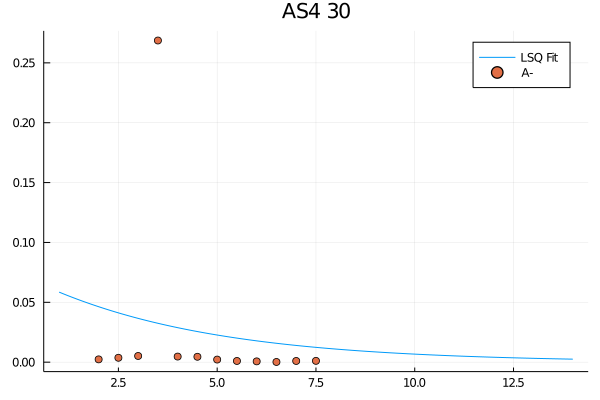

In [187]:
i = 7
    plot(x, titration_curve.(res_hil[i], res_pka[i], x),
        label = "LSQ Fit",
        title = string(titrable_resnames[i], " ", titrable_resis[i]))
    
    scatter!(xdata, deprotonated_fraction2[i, :],
        label = "A-")
    
    annotate!((res_pka[i] + 1.5), .5, 
        Plots.text(string("pKa = ", round(res_pka[i], digits = 2))))
    annotate!((res_pka[i] + 1.2), .4, 
        Plots.text(string("n = ", round(res_hil[i], digits = 2))))

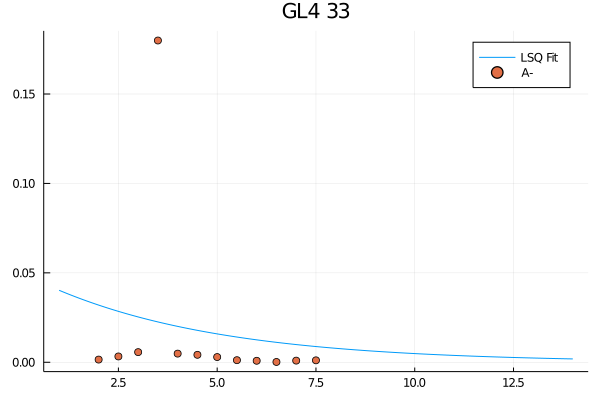

In [188]:
i = 8
    plot(x, titration_curve.(res_hil[i], res_pka[i], x),
        label = "LSQ Fit",
        title = string(titrable_resnames[i], " ", titrable_resis[i]))
    
    scatter!(xdata, deprotonated_fraction2[i, :],
        label = "A-")
    
    annotate!((res_pka[i] + 1.5), .5, 
        Plots.text(string("pKa = ", round(res_pka[i], digits = 2))))
    annotate!((res_pka[i] + 1.2), .4, 
        Plots.text(string("n = ", round(res_hil[i], digits = 2))))

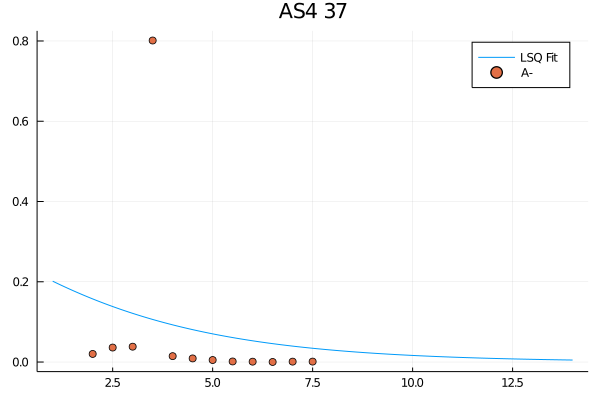

In [189]:
i = 9
    plot(x, titration_curve.(res_hil[i], res_pka[i], x),
        label = "LSQ Fit",
        title = string(titrable_resnames[i], " ", titrable_resis[i]))
    
    scatter!(xdata, deprotonated_fraction2[i, :],
        label = "A-")
    
    annotate!((res_pka[i] + 1.5), .5, 
        Plots.text(string("pKa = ", round(res_pka[i], digits = 2))))
    annotate!((res_pka[i] + 1.2), .4, 
        Plots.text(string("n = ", round(res_hil[i], digits = 2))))

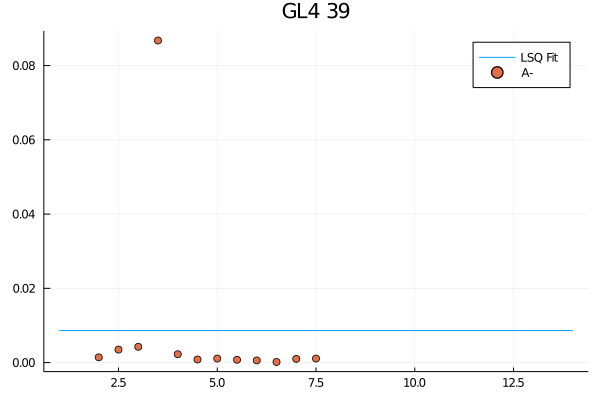

In [190]:
i = 10
    plot(x, titration_curve.(res_hil[i], res_pka[i], x),
        label = "LSQ Fit",
        title = string(titrable_resnames[i], " ", titrable_resis[i]))
    
    scatter!(xdata, deprotonated_fraction2[i, :],
        label = "A-")
    
    annotate!((res_pka[i] + 1.5), .5, 
        Plots.text(string("pKa = ", round(res_pka[i], digits = 2))))
    annotate!((res_pka[i] + 1.2), .4, 
        Plots.text(string("n = ", round(res_hil[i], digits = 2))))

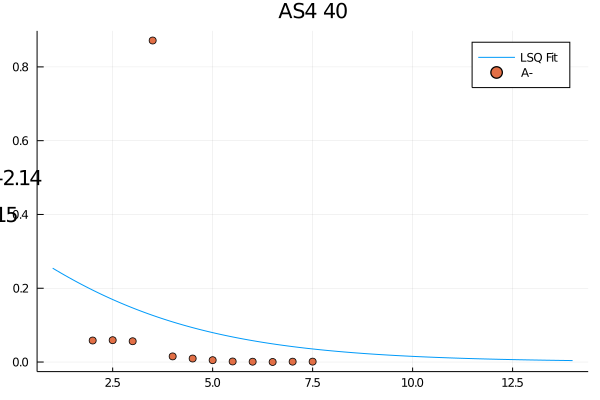

In [191]:
i = 11
    plot(x, titration_curve.(res_hil[i], res_pka[i], x),
        label = "LSQ Fit",
        title = string(titrable_resnames[i], " ", titrable_resis[i]))
    
    scatter!(xdata, deprotonated_fraction2[i, :],
        label = "A-")
    
    annotate!((res_pka[i] + 1.5), .5, 
        Plots.text(string("pKa = ", round(res_pka[i], digits = 2))))
    annotate!((res_pka[i] + 1.2), .4, 
        Plots.text(string("n = ", round(res_hil[i], digits = 2))))

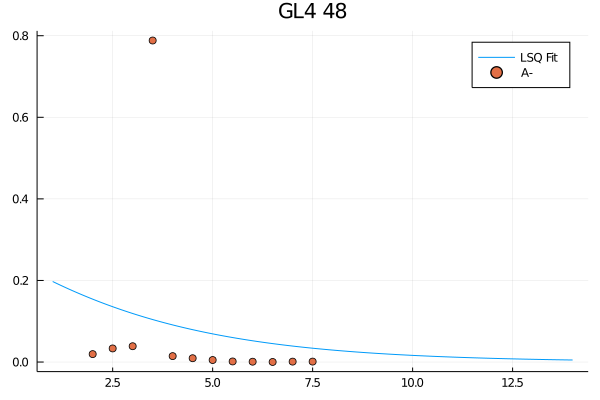

In [192]:
i = 12
    plot(x, titration_curve.(res_hil[i], res_pka[i], x),
        label = "LSQ Fit",
        title = string(titrable_resnames[i], " ", titrable_resis[i]))
    
    scatter!(xdata, deprotonated_fraction2[i, :],
        label = "A-")
    
    annotate!((res_pka[i] + 1.5), .5, 
        Plots.text(string("pKa = ", round(res_pka[i], digits = 2))))
    annotate!((res_pka[i] + 1.2), .4, 
        Plots.text(string("n = ", round(res_hil[i], digits = 2))))

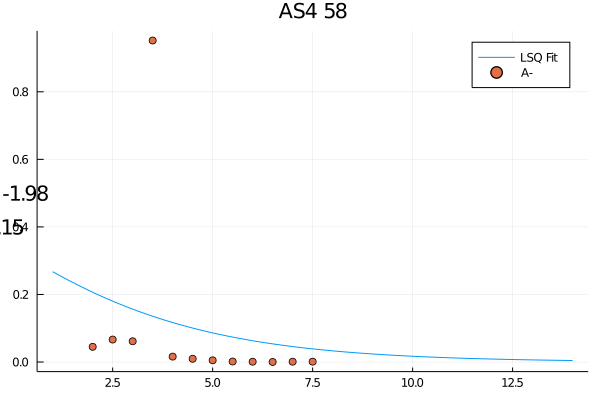

In [193]:
i = 13
    plot(x, titration_curve.(res_hil[i], res_pka[i], x),
        label = "LSQ Fit",
        title = string(titrable_resnames[i], " ", titrable_resis[i]))
    
    scatter!(xdata, deprotonated_fraction2[i, :],
        label = "A-")
    
    annotate!((res_pka[i] + 1.5), .5, 
        Plots.text(string("pKa = ", round(res_pka[i], digits = 2))))
    annotate!((res_pka[i] + 1.2), .4, 
        Plots.text(string("n = ", round(res_hil[i], digits = 2))))

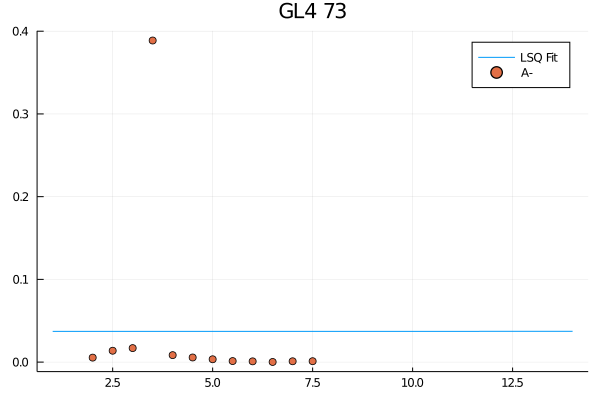

In [194]:
i = 14
    plot(x, titration_curve.(res_hil[i], res_pka[i], x),
        label = "LSQ Fit",
        title = string(titrable_resnames[i], " ", titrable_resis[i]))
    
    scatter!(xdata, deprotonated_fraction2[i, :],
        label = "A-")
    
    annotate!((res_pka[i] + 1.5), .5, 
        Plots.text(string("pKa = ", round(res_pka[i], digits = 2))))
    annotate!((res_pka[i] + 1.2), .4, 
        Plots.text(string("n = ", round(res_hil[i], digits = 2))))

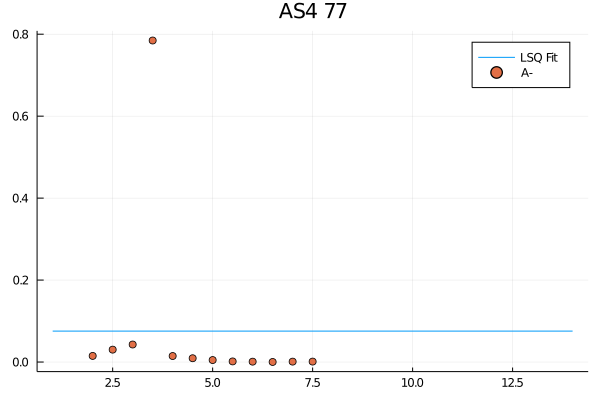

In [195]:
i = 15
    plot(x, titration_curve.(res_hil[i], res_pka[i], x),
        label = "LSQ Fit",
        title = string(titrable_resnames[i], " ", titrable_resis[i]))
    
    scatter!(xdata, deprotonated_fraction2[i, :],
        label = "A-")
    
    annotate!((res_pka[i] + 1.5), .5, 
        Plots.text(string("pKa = ", round(res_pka[i], digits = 2))))
    annotate!((res_pka[i] + 1.2), .4, 
        Plots.text(string("n = ", round(res_hil[i], digits = 2))))

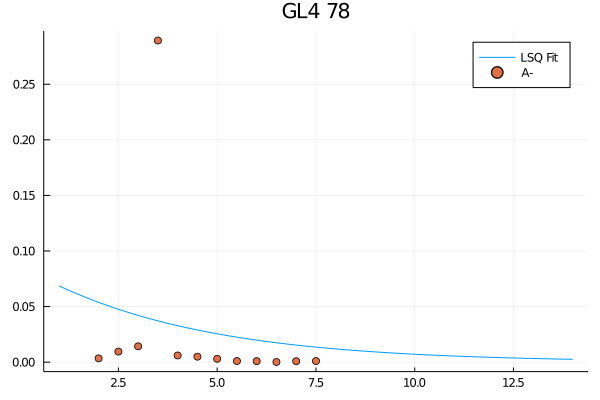

In [196]:
i = 16
    plot(x, titration_curve.(res_hil[i], res_pka[i], x),
        label = "LSQ Fit",
        title = string(titrable_resnames[i], " ", titrable_resis[i]))
    
    scatter!(xdata, deprotonated_fraction2[i, :],
        label = "A-")
    
    annotate!((res_pka[i] + 1.5), .5, 
        Plots.text(string("pKa = ", round(res_pka[i], digits = 2))))
    annotate!((res_pka[i] + 1.2), .4, 
        Plots.text(string("n = ", round(res_hil[i], digits = 2))))

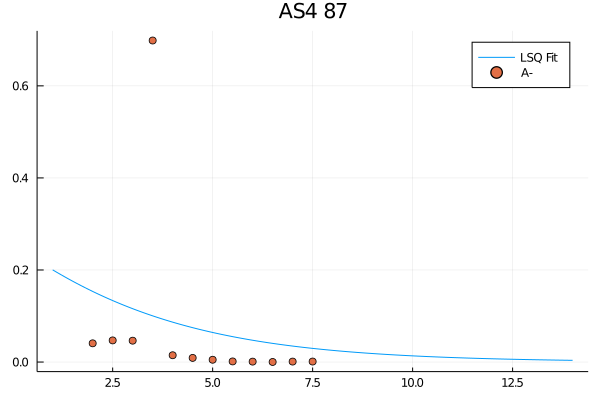

In [197]:
i = 17
    plot(x, titration_curve.(res_hil[i], res_pka[i], x),
        label = "LSQ Fit",
        title = string(titrable_resnames[i], " ", titrable_resis[i]))
    
    scatter!(xdata, deprotonated_fraction2[i, :],
        label = "A-")
    
    annotate!((res_pka[i] + 1.5), .5, 
        Plots.text(string("pKa = ", round(res_pka[i], digits = 2))))
    annotate!((res_pka[i] + 1.2), .4, 
        Plots.text(string("n = ", round(res_hil[i], digits = 2))))

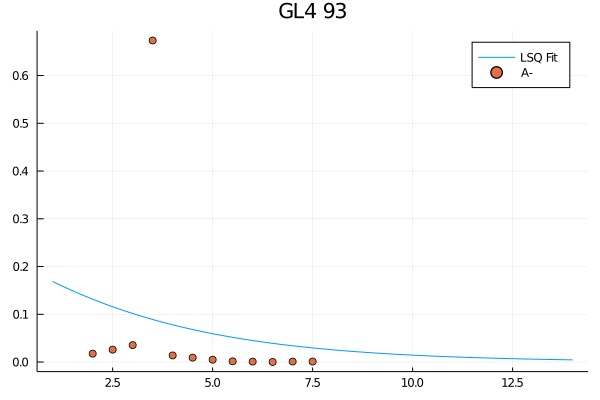

In [198]:
i = 18
    plot(x, titration_curve.(res_hil[i], res_pka[i], x),
        label = "LSQ Fit",
        title = string(titrable_resnames[i], " ", titrable_resis[i]))
    
    scatter!(xdata, deprotonated_fraction2[i, :],
        label = "A-")
    
    annotate!((res_pka[i] + 1.5), .5, 
        Plots.text(string("pKa = ", round(res_pka[i], digits = 2))))
    annotate!((res_pka[i] + 1.2), .4, 
        Plots.text(string("n = ", round(res_hil[i], digits = 2))))

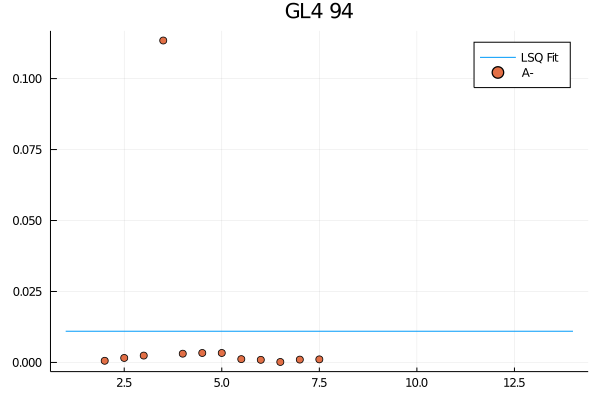

In [199]:
i = 19
    plot(x, titration_curve.(res_hil[i], res_pka[i], x),
        label = "LSQ Fit",
        title = string(titrable_resnames[i], " ", titrable_resis[i]))
    
    scatter!(xdata, deprotonated_fraction2[i, :],
        label = "A-")
    
    annotate!((res_pka[i] + 1.5), .5, 
        Plots.text(string("pKa = ", round(res_pka[i], digits = 2))))
    annotate!((res_pka[i] + 1.2), .4, 
        Plots.text(string("n = ", round(res_hil[i], digits = 2))))

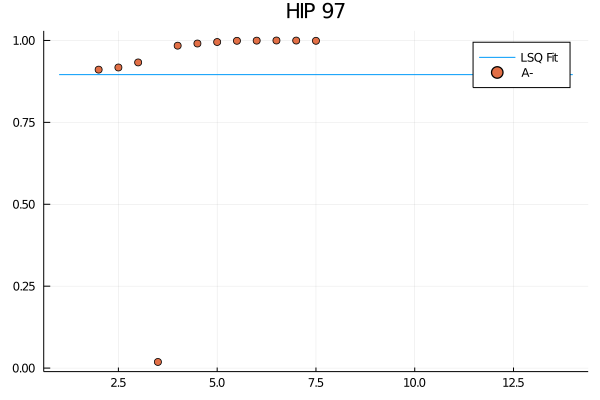

In [200]:
i = 20
    plot(x, titration_curve.(res_hil[i], res_pka[i], x),
        label = "LSQ Fit",
        title = string(titrable_resnames[i], " ", titrable_resis[i]))
    
    scatter!(xdata, deprotonated_fraction2[i, :],
        label = "A-")
    
    annotate!((res_pka[i] + 1.5), .5, 
        Plots.text(string("pKa = ", round(res_pka[i], digits = 2))))
    annotate!((res_pka[i] + 1.2), .4, 
        Plots.text(string("n = ", round(res_hil[i], digits = 2))))

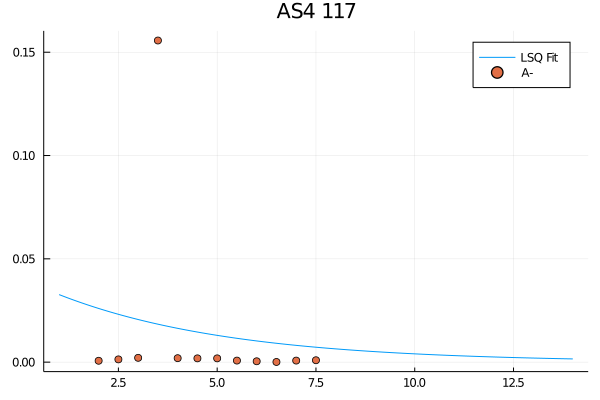

In [201]:
i = 21
    plot(x, titration_curve.(res_hil[i], res_pka[i], x),
        label = "LSQ Fit",
        title = string(titrable_resnames[i], " ", titrable_resis[i]))
    
    scatter!(xdata, deprotonated_fraction2[i, :],
        label = "A-")
    
    annotate!((res_pka[i] + 1.5), .5, 
        Plots.text(string("pKa = ", round(res_pka[i], digits = 2))))
    annotate!((res_pka[i] + 1.2), .4, 
        Plots.text(string("n = ", round(res_hil[i], digits = 2))))